In [3]:
import pynbody as pb
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import photutils as phot
from pynbody.array import SimArray as SRA
from astropy.visualization import simple_norm

In [4]:
def rform(simin, starlog, com_times, COM, long='no'):

    """
    This calculates rform, zform and rformspherical using the starlog
    center of mass.

    Returns: rform, zform, rform_spherical or if long = yes Returns
    xform, yform, zform
    """
    # simin.physical_units()

    # Now load in the posform and store it in x/y/zform variable

    posform = starlog.s['pos'][:len(simin.s)]
    x_starlog = posform[:, 0]
    y_starlog = posform[:, 1]
    z_starlog = posform[:, 2]
    tform = simin.s['tform']

    # Now need to import the COM information from file.
    # data = np.genfromtxt(
    #     fname=comtxt, names='xcom,ycom,zcom,xang,yang,zang')
    xcom = COM[:,0][:len(com_times)]
    ycom = COM[:,1][:len(com_times)]
    zcom = COM[:,2][:len(com_times)]
    xang = COM[:,3][:len(com_times)]
    yang = COM[:,4][:len(com_times)]
    zang = COM[:,5][:len(com_times)]

    # Do a sanity check that xp is increasing (otherwise np.interp returns
    # nonsensical values)
    if(np.all(np.diff(com_times) > 0)):
        xcom_interp = np.interp(tform, com_times, xcom)
        ycom_interp = np.interp(tform, com_times, ycom)
        zcom_interp = np.interp(tform, com_times, zcom)
        xang_interp = np.interp(tform, com_times, xang)
        yang_interp = np.interp(tform, com_times, yang)
        zang_interp = np.interp(tform, com_times, zang)
    else:
        raise Exception('com_times does not increase')

    # Recenter on the COM at that tform
    x_starlog = x_starlog - xcom_interp
    y_starlog = y_starlog - ycom_interp
    z_starlog = z_starlog - zcom_interp

    # Calculate the dot product of rform and the ang mom vectors
    rdotj = (x_starlog*xang_interp +
             y_starlog*yang_interp + z_starlog*zang_interp)
    jmag = np.sqrt(xang_interp**2 + yang_interp**2 + zang_interp**2)

    # Set 0 vectors to something small but non zero
    jmag[jmag == 0] = 0.00000001

    rmag = np.sqrt(x_starlog**2 + y_starlog**2 + z_starlog**2)

    zform = np.empty(len(simin.s))
    zform = rdotj / jmag

    rform = np.empty(len(simin.s))
    rform = np.sqrt(rmag**2 - zform**2)

    rform_spherical = rmag

    if long == 'no':
        return SRA(rform,units='kpc'), SRA(zform,units='kpc'), SRA(rform_spherical,units='kpc')
    if long == 'yes':
        return SRA(x_starlog,units='kpc'), SRA(y_starlog,units='kpc'), SRA(z_starlog,units='kpc')

In [5]:
def RotateBack(x,y,dtime,vcirc):
    # Rotate stars back in time
    lindist = vcirc*dtime #linear distance traveled in time interval
    rho = (x**2+y**2)**(1/2) #distance from z axis
    nrot = lindist/(2*np.pi*rho) #number of rotations
    nrotints = lindist//(2*np.pi*rho) #integer number of rotations
    rotangle = nrot-nrotints #partial rotation
    rotanglerad = 2*np.pi*rotangle #convert to radians
    xrot = x*np.cos(-rotanglerad)-y*np.sin(-rotanglerad) #x position at beginning of interval
    yrot = x*np.sin(-rotanglerad)+y*np.cos(-rotanglerad) #y position at beginning of interval
    return xrot,yrot

In [6]:
def FindPeaks(data,z):
    # Find peaks in 2D array of data
    statsdata = list(np.ravel(data)[np.flatnonzero(data)]) #only includes data points with density greater than 1 to calculate threshold
    # while 1 in statsdata:
    #   statsdata.remove(1)
    median = np.median(statsdata)
    std = np.std(statsdata)
    threshold = median + (z * std) #minimum density for a peak
    tbl = phot.find_peaks(data, threshold, box_size=0) #table of x index, y index, and density for peaks
    tbl['peak_value'].info.format = '%.8g'
    return tbl

In [7]:
def make_unique(original_list):
    # Takes a list and returns it without duplicate entries
    unique_list = []
    [unique_list.append(obj) for obj in original_list if obj not in unique_list]
    return unique_list

In [8]:
def CombineClose(positions,cutclumps):
    # Combine multiple peaks in the same star cluster
    peaks = []
    closelist = []
    for i in range(0,len(positions[0])):
        jlist = [i] #a list containing that peak and other peaks near it
        for j in range(i+1,len(positions[0])):
            xi = positions[0][i]
            yi = positions[1][i]
            xj = positions[0][j]
            yj = positions[1][j]
            dist2 = (xi-xj)**2+(yi-yj)**2
            if dist2<0.1:
                jlist.append(j)
        closelist.append(jlist) #a list where each element is a list of nearby peaks
    for i in range(0,len(closelist)):
        if len(closelist[i])>1:
            for j in closelist[i]:
                if i==j:
                    continue
                closelist[j] = closelist[i]
        elif cutclumps:
            closelist[i] = 0
    closelist = make_unique(closelist) #remove elements of closelist that contain the same peaks
    for i in closelist:
        if i == 0:
            closelist.remove(0)
            break
    for i in closelist:
        sumx = 0
        sumy = 0
        for j in i:
            sumx = sumx+positions[0][j]
            sumy = sumy+positions[1][j]
        meanx = sumx/len(i) #mean x position of a close group of peaks
        meany = sumy/len(i) #mean y position of a close group of peaks
        peaks.append([meanx,meany])
    xcoords = []
    ycoords = []
    for peak in peaks:
        xcoords.append(peak[0])
        ycoords.append(peak[1])
    xcoords = np.array(xcoords) #array of peak x coordinates
    ycoords = np.array(ycoords) #array of peak y coordinates
    peaks1 = (xcoords,ycoords)
    return peaks1

In [9]:
def MeanPeaks(starlist,positions):
    # Make the x and y positions of the clumps equal to the mean x and y positions of the stars, rather than peak location
    x = []
    y = []
    for i in range(0,len(positions[0])):
        inclump = ((starlist['XROT']-positions[0][i])**2+(starlist['YROT']-positions[1][i])**2<0.09) #true for stars within aperture
        clump = starlist[inclump] #only includes stars in clump
        x.append(np.mean(clump['XROT']))
        y.append(np.mean(clump['YROT']))
    x = np.array(x) #array of mean x coordinates of clump
    y = np.array(y) #array of mean y coordinates of clump
    meanPositions = (x,y)
    return meanPositions

In [10]:
def TrackClumps(clumps,xcoords,ycoords,stars,merges,mergemax):
    # Make center clump #1 in first timestep
    if len(clumps)==0:
        for i in range(0,len(xcoords)):
            if xcoords[i]**2+ycoords[i]**2<0.09:
                inclump = ((stars['XROT']-xcoords[i])**2+(stars['YROT']-ycoords[i])**2<0.09)
                clumpStars = stars[inclump] #only includes stars in clump
                nstars = len(clumpStars)
                txyn = [start,xcoords[i],ycoords[i],nstars]
                clumpID = 1
                clumps = [[clumpID,list(clumpStars['INDEX']),txyn]]
                xcoords = list(xcoords)
                ycoords = list(ycoords)
                xcoords.pop(i)
                ycoords.pop(i)
                break
    # Match clumps in current timestep to clumps in previous timesteps
    leftx = np.array(xcoords)
    lefty = np.array(ycoords)
    lefti = []
    for i in range(0,len(leftx)):
        lefti.append(i)
    xleft = []
    yleft = []
    ileft = []
    if len(clumps)>0:
        for i in range(0,len(xcoords)): #run through clumps in current timestep
            newMerge = []
            matchFound = False
            if clumps[0][-1][0]<start-5*dt and xcoords[i]**2+ycoords[i]**2<0.25:
                matchFound = True
                newMerge = [start,1,1]
            for skip in range(1,5): #run through the previous 4 timesteps
                clumpsrho = (leftx**2+lefty**2)**(1/2)
                clumpsvcirc = np.interp(clumpsrho,profs['rbins'],profs['v_circ'])
                cxrot,cyrot = RotateBack(leftx,lefty,skip*dt,clumpsvcirc) #move clumps back in time
                xi = cxrot[i]
                yi = cyrot[i]
                for clump in clumps: #run through clumps from previous timesteps
                    newest = clump[len(clump)-1] #[time,x,y] of the most recent location of the clump
                    if newest[0]==round(start-skip*dt,3): #only look at clumps that were found recently
                        xj = newest[1]
                        yj = newest[2]
                        if (xi-xj)**2+(yi-yj)**2<0.25:
                            if not matchFound:
                                newMerge = [start,1,clump[0]]
                                matchFound = True
                            else:
                                newMerge.append(clump[0])
            if matchFound:
                newMerge[2:] = np.sort(newMerge[2:])
                if len(newMerge)>3:
                    extras = newMerge[3:]
                    for clump in clumps:
                        for j in extras:
                            if clump[0]==j and len(clump)<27:
                                extras.remove(j)
                    newMerge = newMerge[0:3]+extras
                newMerge[1] = len(newMerge)-2
                for clump in clumps:
                    if clump[0]==newMerge[2]:
                        inclump = ((stars['XROT']-leftx[i])**2+(stars['YROT']-lefty[i])**2<0.09)
                        clumpStars = stars[inclump] #only includes stars in clump
                        nstars = len(clumpStars)
                        clump.append([start,xcoords[lefti[i]],ycoords[lefti[i]],nstars])
                        clump[1] = clump[1]+list(clumpStars['INDEX'])
                        clump[1] = make_unique(clump[1])
            if len(newMerge) > 3:
                mergeMatch = False
                for merge in merges:
                    if len(newMerge)==len(merge) and np.all(newMerge[2:]==merge[2:]):
                        mergeMatch = True
                        break
                if not mergeMatch:
                    merges.append(newMerge)
                    if len(newMerge) > mergemax:
                        mergemax = len(newMerge)
                    print(' New merge: {0}'.format(newMerge))
            if not matchFound: #make a list of clumps that do not match clumps seen earlier
                xleft.append(leftx[i])
                yleft.append(lefty[i])
                ileft.append(lefti[i])
        leftx = np.array(xleft)
        lefty = np.array(yleft)
        lefti = ileft
    for i in range(0,len(lefti)): #add clumps that don't match older ones to the end of the list
        inclump = ((stars['XROT']-leftx[i])**2+(stars['YROT']-lefty[i])**2<0.09)
        clumpStars = stars[inclump] #only includes stars in clump
        nstars = len(clumpStars)
        if len(clumps) == 0:
            clumpID = 1
        else:
            clumpID = clumps[len(clumps)-1][0]+1
        clumps.append([clumpID,list(clumpStars['INDEX']),[start,xcoords[lefti[i]],ycoords[lefti[i]],nstars]])
    return clumps,merges,mergemax

In [11]:
def rform(simin, starlog, com_times,comtxt, long='no'):

    """
    This calculates rform, zform and rformspherical using the starlog
    center of mass.

    Returns: rform, zform, rform_spherical or if long = yes Returns
    xform, yform, zform
    """
    # simin.physical_units()

    # Now load in the posform and store it in x/y/zform variable

    posform = starlog.s['pos'][:len(simin.s)]
    x_starlog = posform[:, 0]
    y_starlog = posform[:, 1]
    z_starlog = posform[:, 2]
    tform = simin.s['tform']

    # Now need to import the COM information from file.
    # data = np.genfromtxt(
    #     fname=comtxt, names='xcom,ycom,zcom,xang,yang,zang')
    xcom = COM[:,0][:len(com_times)]
    ycom = COM[:,1][:len(com_times)]
    zcom = COM[:,2][:len(com_times)]
    xang = COM[:,3][:len(com_times)]
    yang = COM[:,4][:len(com_times)]
    zang = COM[:,5][:len(com_times)]

    # Do a sanity check that xp is increasing (otherwise np.interp returns
    # nonsensical values)
    if(np.all(np.diff(com_times) > 0)):
        xcom_interp = np.interp(tform, com_times, xcom)
        ycom_interp = np.interp(tform, com_times, ycom)
        zcom_interp = np.interp(tform, com_times, zcom)
        xang_interp = np.interp(tform, com_times, xang)
        yang_interp = np.interp(tform, com_times, yang)
        zang_interp = np.interp(tform, com_times, zang)
    else:
        raise Exception('com_times does not increase')

    # Recenter on the COM at that tform
    x_starlog = x_starlog - xcom_interp
    y_starlog = y_starlog - ycom_interp
    z_starlog = z_starlog - zcom_interp

    # Calculate the dot product of rform and the ang mom vectors
    rdotj = (x_starlog*xang_interp +
             y_starlog*yang_interp + z_starlog*zang_interp)
    jmag = np.sqrt(xang_interp**2 + yang_interp**2 + zang_interp**2)

    # Set 0 vectors to something small but non zero
    jmag[jmag == 0] = 0.00000001

    rmag = np.sqrt(x_starlog**2 + y_starlog**2 + z_starlog**2)

    zform = np.empty(len(simin.s))
    zform = rdotj / jmag

    rform = np.empty(len(simin.s))
    rform = np.sqrt(rmag**2 - zform**2)

    rform_spherical = rmag

    if long == 'no':
        return SRA(rform,units='kpc'), SRA(zform,units='kpc'), SRA(rform_spherical,units='kpc')
    if long == 'yes':
        return SRA(x_starlog,units='kpc'), SRA(y_starlog,units='kpc'), SRA(z_starlog,units='kpc')

In [12]:
COM=np.zeros((40,6))
r=pb.filt.BandPass('r','0 kpc','2 kpc')
k=0
for i in range(10,410,10):
  sim=pb.load('run733DiffFB10T1.0.%05d'%i)
  COM[k][:3]=pb.analysis.halo.center(sim,mode='hyb',retcen=True)
  pb.analysis.halo.center(sim,mode='hyb',retcen=False)
  COM[k][3:]=pb.analysis.angmom.ang_mom_vec(sim.s[r])
  k+=1
sim=pb.load('run733DiffFB10T1.0.%05d'%400)
starlog=pb.tipsy.StarLog('run733DiffFB10T1.0.starlog')
FORM=rform(sim,starlog,np.arange(0.1,4,.1),COM,long='yes')
sim.s['x_form'],sim.s['y_form'],sim.s['z_form']=FORM
sim.s['t_form'] = starlog['tform'][0:len(sim.s)]

refTime = 15


pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


refTime = 16


pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


 New merge: [1.625, 2, 3, 8]
refTime = 17


pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


 New merge: [1.668, 2, 4, 5]
 New merge: [1.732, 2, 3, 4]
22 clumps total


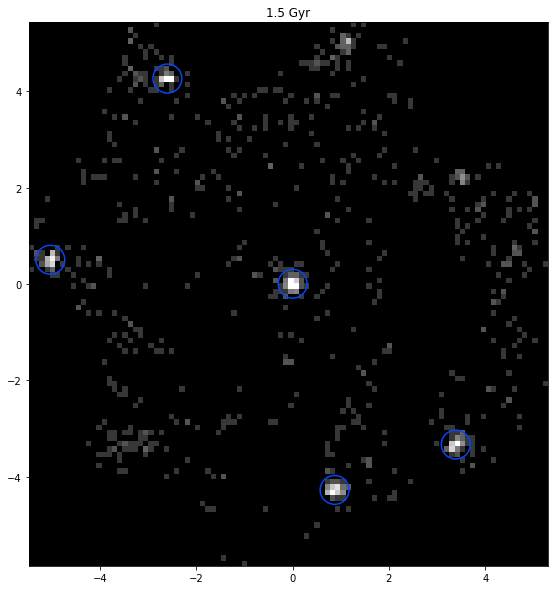

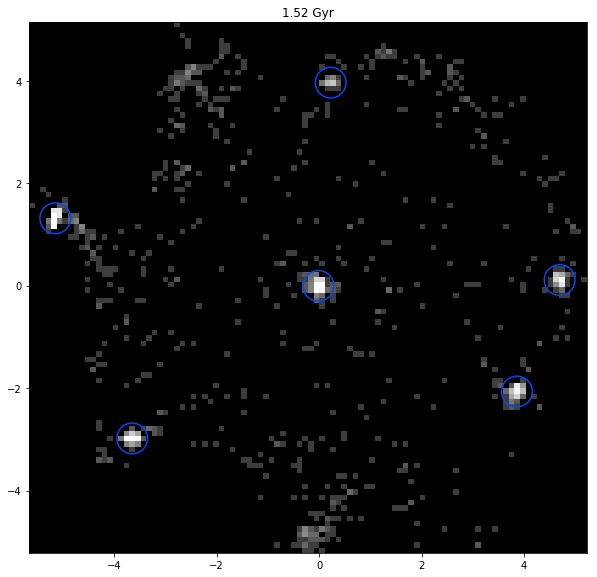

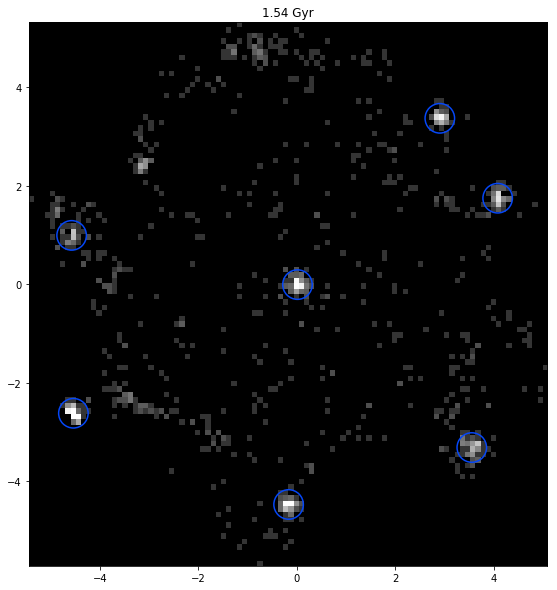

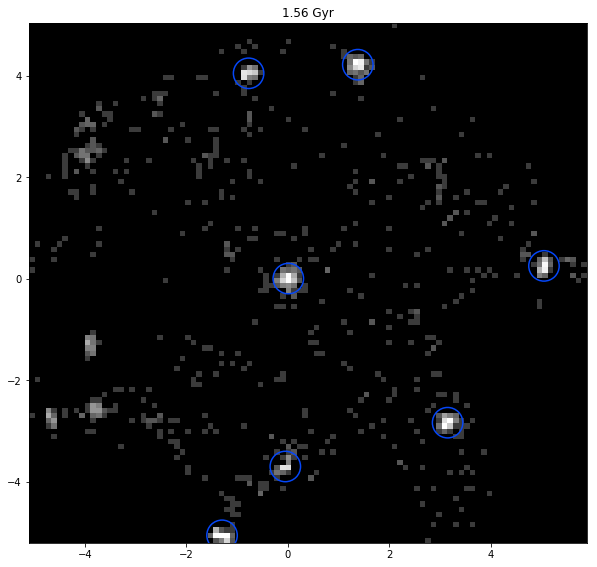

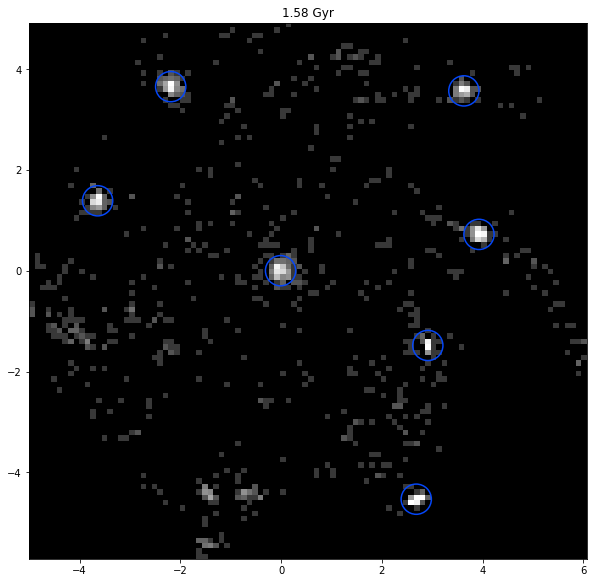

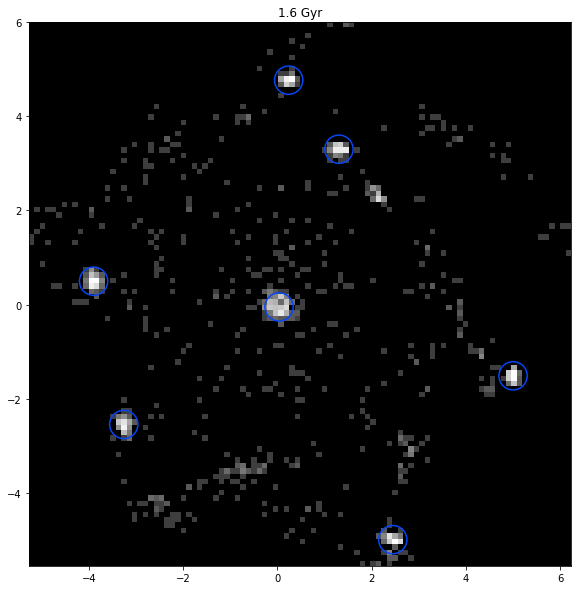

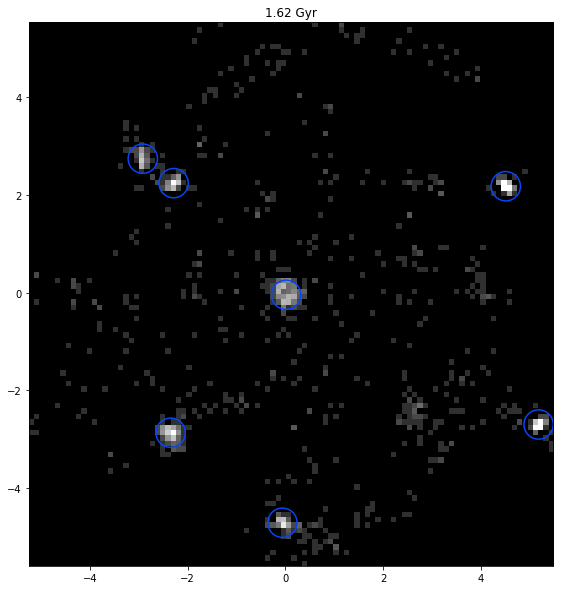

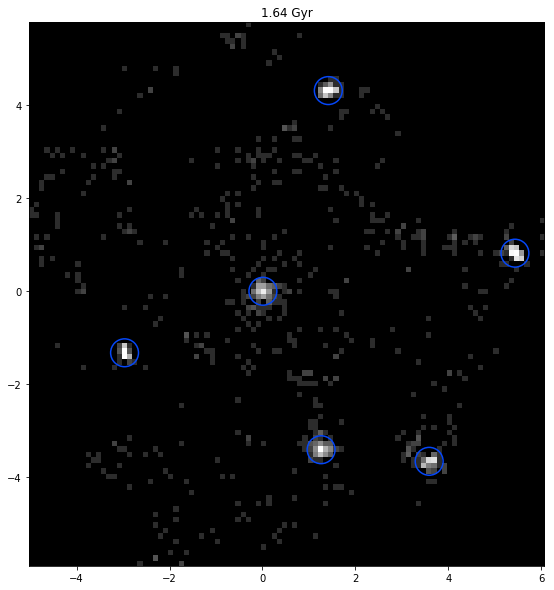

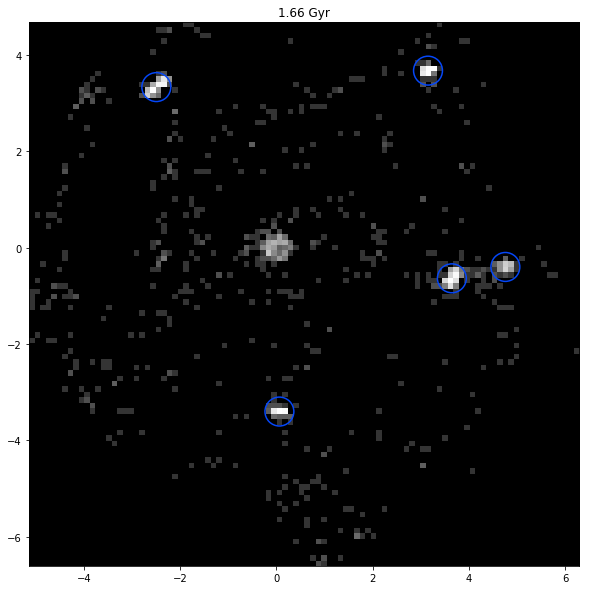

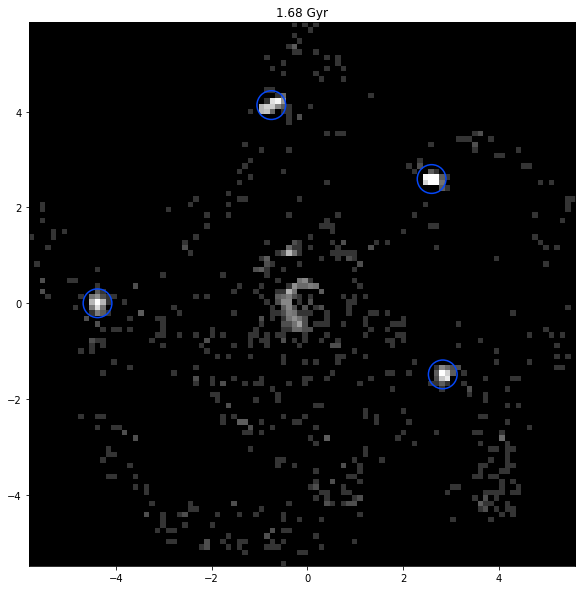

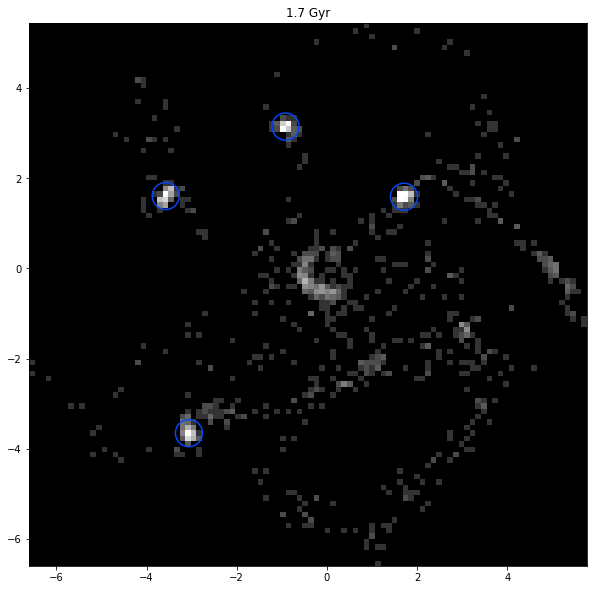

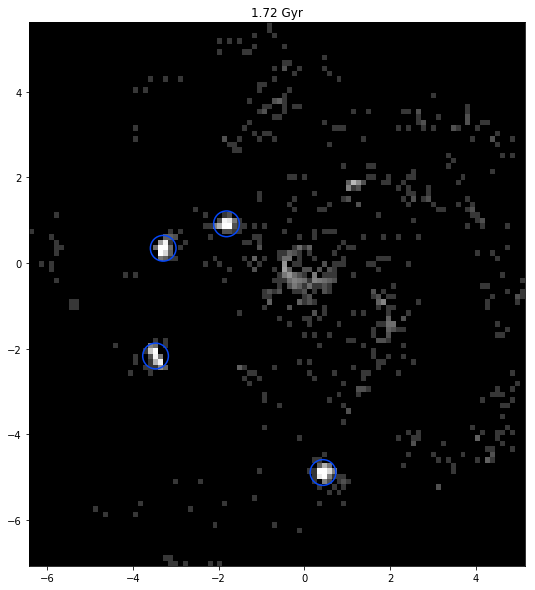

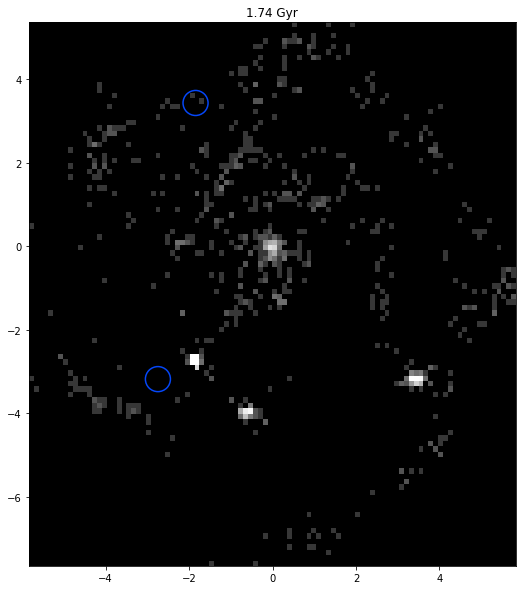

In [13]:
# Read txyz file
txyz = sim.s
index = np.linspace(0,len(txyz)-1,len(txyz))
txyz['INDEX'] = index
rho = np.sqrt(txyz['x_form']**2+txyz['y_form']**2)
txyz['RHO'] = rho
start = 1.5
dt = 0.001
clumps = []
oldClumps = []
merges = []
mergemax = 0

for refTime in range(15,18):
    print('refTime = {0}'.format(refTime))
    # Read snapshot file
    a00 = refTime*10
    snapshot = pb.load('run733DiffFB10T1.0.%05d'%a00)
    # Make the origin the center of mass
    pb.analysis.halo.center(snapshot,mode='hyb')
    pb.analysis.angmom.faceon(snapshot.s)
    snapshot2 = snapshot[pb.filt.BandPass('rxy','0 kpc','13 kpc')]

    # Interpolate vDisk as a function of rho
    profs=pb.analysis.profile.Profile(snapshot.s,bins=np.linspace(0,13,130))
    vDisk = np.interp(txyz['RHO'],profs['rbins'],profs['v_circ'].in_units('kpc Gyr**-1'))
    txyz['vDisk'] = vDisk
    # bins = 30
    # medians,binEdges,binNumber = stats.binned_statistic(snapshot2['R'],snapshot2['VTH'],'median',bins)
    # edges = []
    # for i in range(0,len(binEdges)-1):
    #     edges.append((binEdges[i]+binEdges[i+1])/2)
    # w = np.isnan(medians)
    # medians[w] = 0
    # vDisk = UnivariateSpline(edges,medians,~w)

    while round(start*10)==refTime and start<4:
        #Find stars that formed in time interval
        end = start+5*dt
        inint = pb.filt.BandPass('t_form','{} Gyr'.format(start),'{} Gyr'.format(end))
        newStars = txyz[inint]
        #outOfCenter = (newStars['RHO'] > 0.15)
        #newStars = newStars[outOfCenter]

        # Move stars back in time to beginning of interval
        vcirc = newStars['vDisk']
        dtime = newStars['t_form'].in_units('Gyr')-start
        xrot,yrot = RotateBack(newStars['x_form'],newStars['y_form'],dtime,vcirc)
        newStars['XROT'] = xrot
        newStars['YROT'] = yrot
        im, xedges, yedges  = np.histogram2d (-yrot,xrot,(100,100))
        dx = xedges[1]-xedges[0]
        dy = yedges[1]-yedges[0]
        extent = [yedges[0], yedges[-1], -xedges[-1], -xedges[0]]

        # Find peaks in density
        tbl = FindPeaks(im,1.5)

        if len(tbl)>0:
            # Combine clumps in the same place and make clump positions the mean x and y of stars in the clump
            peakPositions = (yedges[tbl['x_peak']]+dy/2, -xedges[tbl['y_peak']]-dx/2)
            peaks = CombineClose(peakPositions,True)
            peaks = MeanPeaks(newStars,peaks)
            peaks = CombineClose(peaks,False)
            positions = MeanPeaks(newStars,peaks)

            # Track clumps through time
            xcoords = positions[0]
            ycoords = positions[1]
            clumps,merges,mergemax = TrackClumps(clumps,xcoords,ycoords,newStars,merges,mergemax)

            if start*50==round(start*50):
                # Plot density plots with clumps
                apertures = phot.CircularAperture(peaks, r=0.3)
                norm = simple_norm(im, 'sqrt', percent=99.9)
                plt.figure(figsize=(10,10))
                plt.imshow(im, cmap='Greys_r', norm=norm, extent=extent)
                apertures.plot(color='#0547f9', lw=1.5)
                plt.title("{0} Gyr".format(start))

        start = round(start+dt,3)
    newClumps = []
    for clump in clumps:
        if clump[0]==1 or clump[len(clump)-1][0] > start-5*dt or clump == clumps[len(clumps)-1]:
            newClumps.append(clump)
        else:
            oldClumps.append(clump)
    clumps = newClumps
clumps = oldClumps+clumps
order = []
for clump in clumps:
    order.append(clump[0])
ordered = list(np.zeros(len(clumps)))
for i,clump in zip(order,clumps):
    ordered[i-1] = clump
clumps = []
for clump in ordered:
    #if len(clump)>26:
    clumps.append(clump)
print('{0} clumps total'.format(len(clumps)))

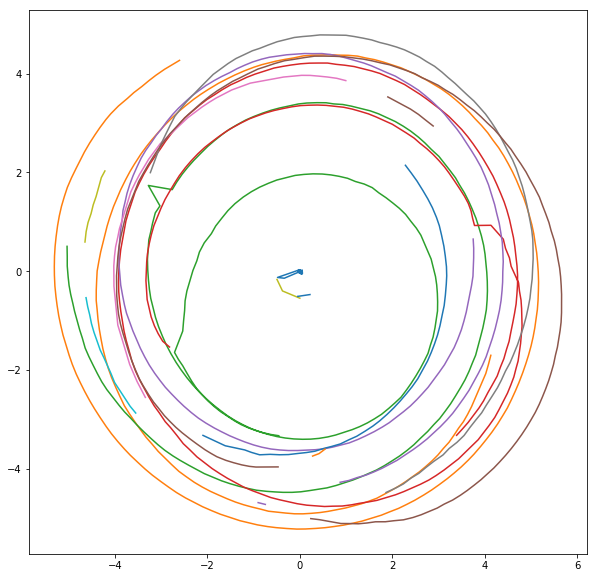

In [14]:
#Plot locations of clumps through time
plt.figure(figsize=(10,10))
for clump in clumps:
    txy = np.array(clump[2:])
    txy2 = np.transpose(txy)
    x = txy2[1]
    y = txy2[2]
    plt.plot(x,y)
# plt.imshow(im, cmap='Greys_r', extent=extent)